EC & KT dataset, bar radar & imshow

In [1]:
import json
import torch
import seaborn
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['font.sans-serif'] = ['DengXian']  
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
with open('glove.6B.50d.txt', 'rb') as f:
    lines = f.readlines()

trained_dict = dict()
for i in range(len(lines)):
    line = lines[i].split()
    trained_dict[line[0].decode("utf-8").lower()] = [float(line[j]) for j in range(1, 51)]

In [3]:
def coo_reduction(itm_lst, exe_lst=None):
    coo = np.array([[0] * 8] * 8)
    tot = np.array([0] * 8).reshape(-1, 1)
    exe_lst = [1] * 1500 if exe_lst is None else exe_lst
    for idx, itm in enumerate(itm_lst):
        cls = np.array(itm['class']).reshape(-1, 1)
        tot += cls * exe_lst[idx]
        cls = np.matmul(cls, cls.transpose())
        coo += cls * exe_lst[idx]
    coo = coo.tolist()
    tot = tot.reshape(-1).tolist()
    for idx in range(8):
        for jdx in range(8):
            coo[idx][jdx] /= tot[idx]
    return np.array(coo)

In [4]:
with open('./ec_train_data.json', 'r', encoding='utf8') as train_data:
    train_geo = json.load(train_data)
with open('./ec_test_data.json', 'r', encoding='utf8') as test_data:
    test_geo = json.load(test_data)
    total_geo = train_geo + test_geo

In [5]:
tot_dct = [0] * 1500
f_data = open('./exercise_data_b.txt', 'r')
for lineID, line in enumerate(f_data):
    line = '[' + line.strip() + ']'
    if lineID % 4 == 1:
        pro_s = eval(line)
        for pid in pro_s:
            tot_dct[pid] += 1
f_data.close()
tra_dct = [0] * 1500
f_data = open('./kt_train_data.txt', 'r')
for lineID, line in enumerate(f_data):
    line = '[' + line.strip() + ']'
    if lineID % 4 == 1:
        pro_s = eval(line)
        for pid in pro_s:
            tra_dct[pid] += 1
f_data.close()

In [6]:
def get_type_lst(dict_lst, exe_lst=None):
    type_lst = [0] * 8
    exer_lst = [0] * 8
    word_dct = {'unknown': {'tot': 0, 'num': [0] * 8}, }
    exe_lst = [1] * 1500 if exe_lst is None else exe_lst
    tot_num = 0
    
    for item in dict_lst:
        s = item['content'].lower()
        words = s.split()
        for word in words:
            if word not in word_dct:
                if word in trained_dict:
                    word_dct[word] = {'tot': 1, 'num': item['class']}
                else:
                    temp = np.array(word_dct['unknown']['num']) + np.array(item['class']) * exe_lst[item['questionId']]
                    word_dct['unknown']['num'] = temp.tolist()
                    word_dct['unknown']['tot'] += 1 * exe_lst[item['questionId']]
            else:
                temp = np.array(word_dct[word]['num']) + np.array(item['class']) * exe_lst[item['questionId']]
                word_dct[word]['num'] = temp.tolist()
                word_dct[word]['tot'] += 1 * exe_lst[item['questionId']]
            type_lst = np.array(type_lst) + np.array(item['class']) * exe_lst[item['questionId']]
            type_lst = type_lst.tolist()
        exer_lst = np.array(exer_lst) + np.array(item['class']) * exe_lst[item['questionId']]
        exer_lst = exer_lst.tolist()
        tot_num += 1 * exe_lst[item['questionId']]
    exer_lst = np.array(exer_lst) / tot_num
    exer_lst = exer_lst.tolist()
    return type_lst, word_dct, exer_lst

In [7]:
type_tra_ec, word_tra_ec, exer_tra_ec = get_type_lst(train_geo)
type_glo_ec, word_glo_ec, exer_glo_ec = get_type_lst(total_geo)
type_tra_kt, word_tra_kt, exer_tra_kt = get_type_lst(total_geo, tra_dct)
type_glo_kt, word_glo_kt, exer_glo_kt = get_type_lst(total_geo, tot_dct)

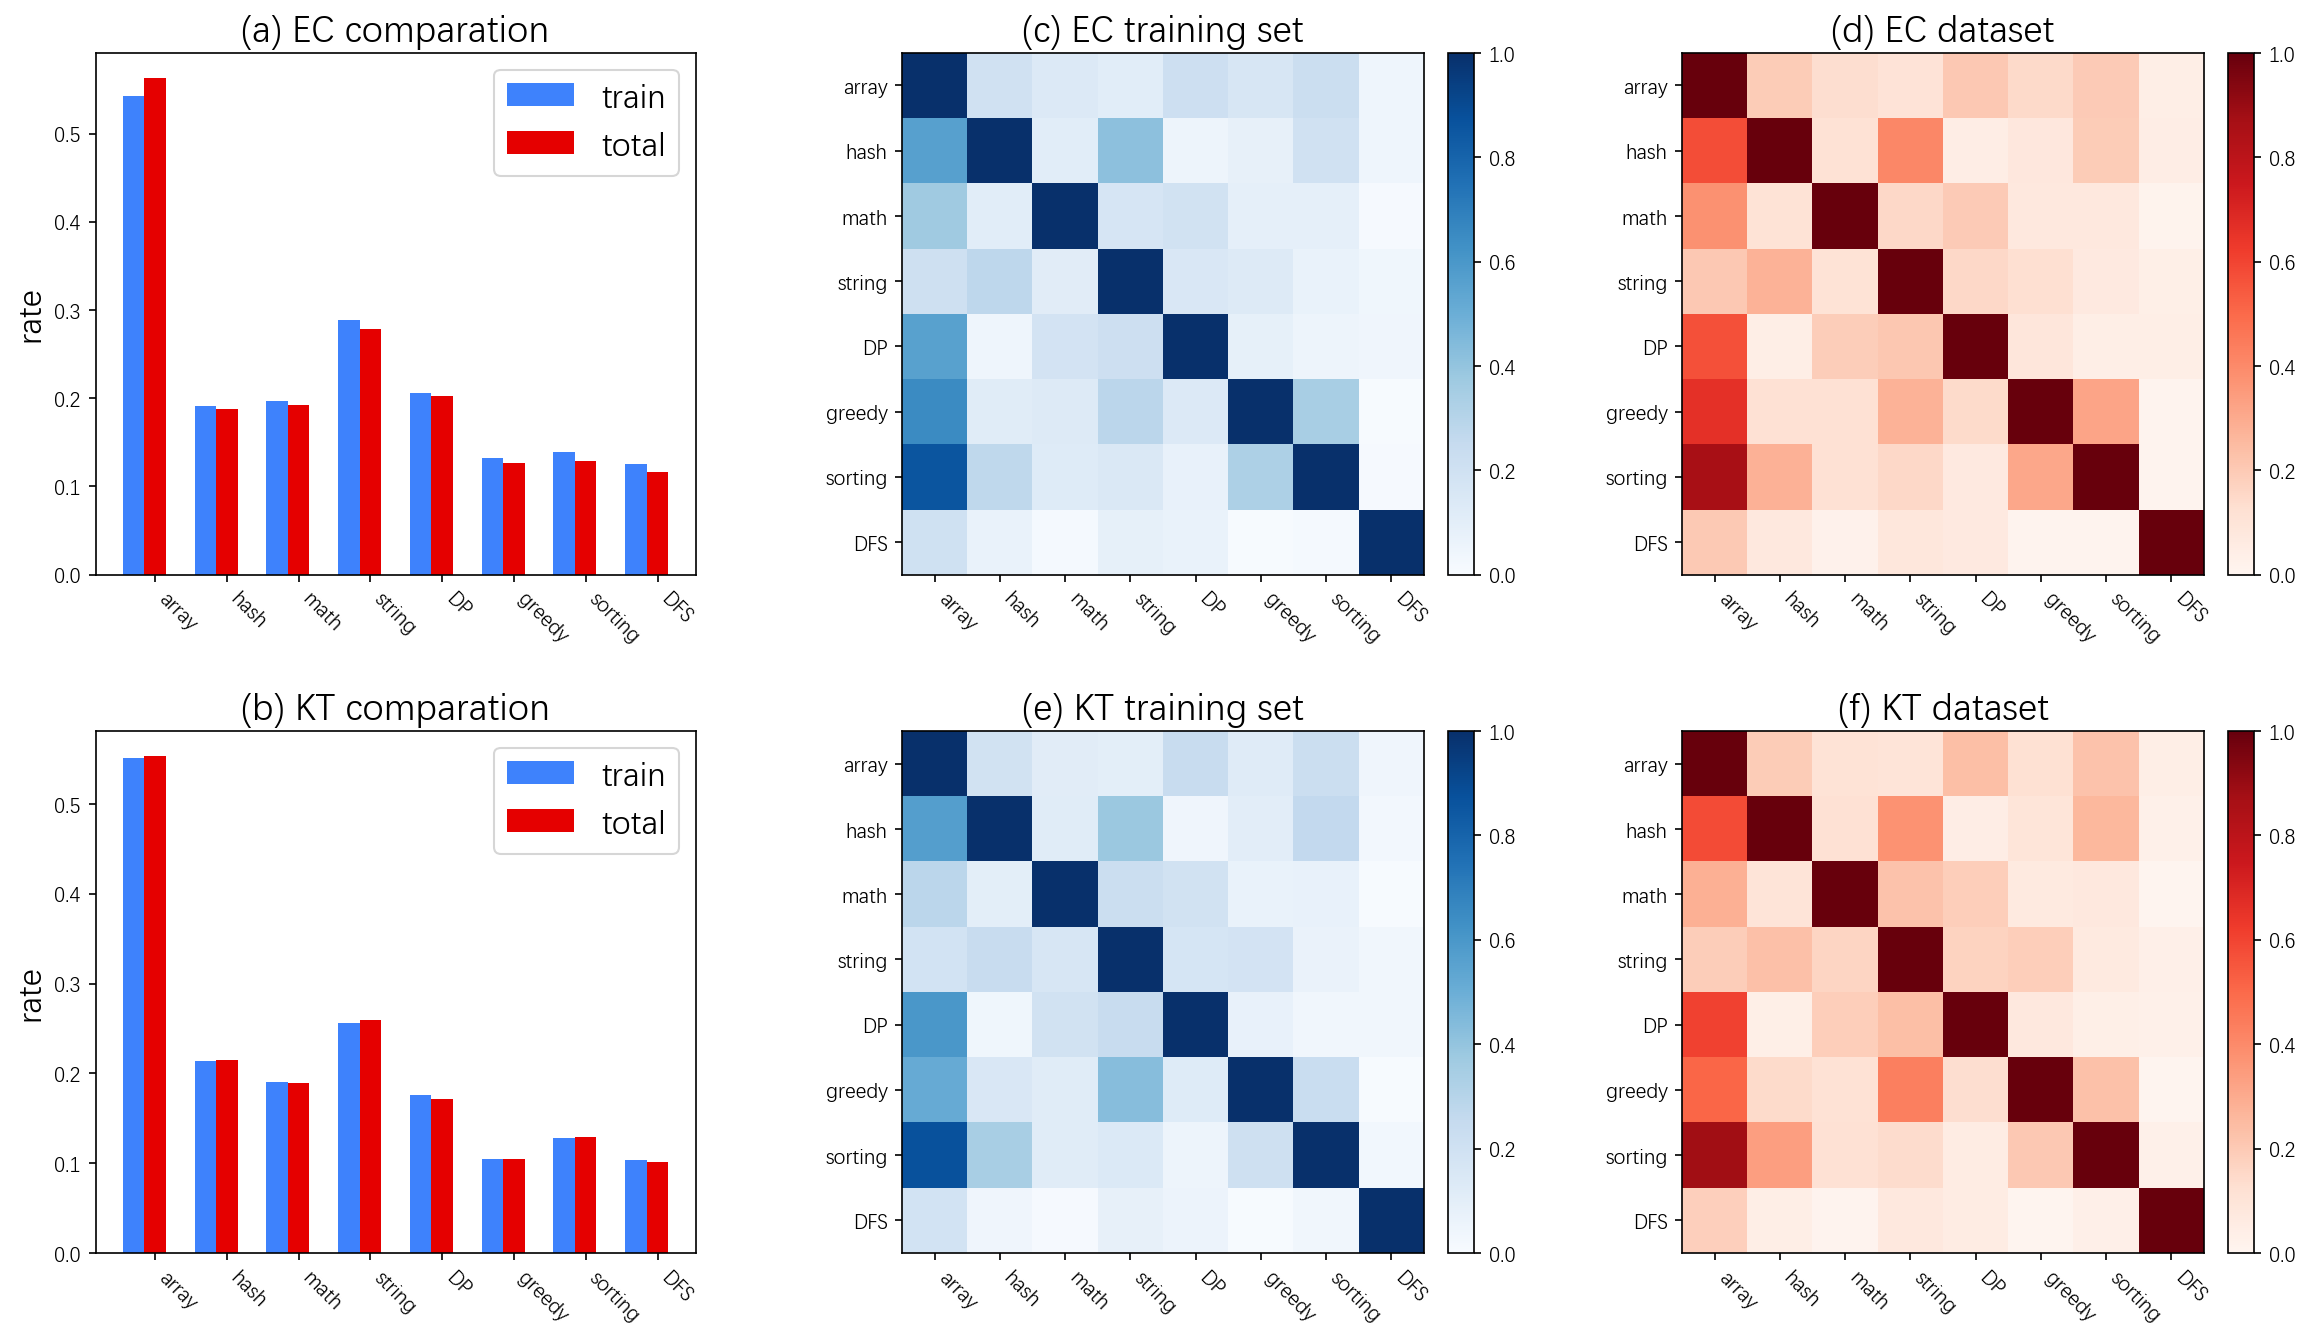

In [8]:
fig = plt.figure(num=1, figsize=(18, 10), dpi=150, clear=True)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, hspace=0.3, wspace=0.3)
ttl_list = ['(a) EC comparation', '(c) EC training set', '(d) EC dataset', 
            '(b) KT comparation', '(e) KT training set', '(f) KT dataset',]
lbl_list = ['array', 'hash', 'math', 'string', 'DP', 'greedy', 'sorting', 'DFS']
bar_width = 0.3
x = np.arange(8)
c = ['dodger blue', 'red']

axe = fig.add_subplot(2, 3, 1)
axe.bar(x - 1 / 2 * bar_width, np.array(exer_tra_ec), bar_width,
        color=seaborn.xkcd_rgb[c[0]], align="center", tick_label=lbl_list, label='train')
axe.bar(x + 1 / 2 * bar_width, np.array(exer_glo_ec), bar_width,
        color=seaborn.xkcd_rgb[c[1]], align="center", tick_label=lbl_list, label='total')
axe.set_xticklabels(lbl_list, rotation=-45, ha='left')
axe.legend(loc='upper right', fontsize=16)
axe.set_ylabel("rate", fontsize=16)
axe.set_title(ttl_list[0], fontsize=18)

axe = fig.add_subplot(2, 3, 2)
coo_mat = coo_reduction(train_geo)
img = axe.imshow(coo_mat, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)
axe.set_xticks(range(len(lbl_list)))
axe.set_xticklabels(lbl_list, rotation=-45, ha='left')
axe.set_yticks(range(len(lbl_list)))
axe.set_yticklabels(lbl_list)
axe.set_title(ttl_list[1], fontsize=18)
plt.colorbar(img, fraction=0.046, pad=0.04)

axe = fig.add_subplot(2, 3, 3)
coo_mat = coo_reduction(total_geo)
img = axe.imshow(coo_mat, interpolation='nearest', cmap=plt.cm.Reds, vmin=0, vmax=1)
axe.set_xticks(range(len(lbl_list)))
axe.set_xticklabels(lbl_list, rotation=-45, ha='left')
axe.set_yticks(range(len(lbl_list)))
axe.set_yticklabels(lbl_list)
axe.set_title(ttl_list[2], fontsize=18)
plt.colorbar(img, fraction=0.046, pad=0.04)

axe = fig.add_subplot(2, 3, 4)
axe.bar(x - 1 / 2 * bar_width, np.array(exer_tra_kt), bar_width,
        color=seaborn.xkcd_rgb[c[0]], align="center", tick_label=lbl_list, label='train')
axe.bar(x + 1 / 2 * bar_width, np.array(exer_glo_kt), bar_width,
        color=seaborn.xkcd_rgb[c[1]], align="center", tick_label=lbl_list, label='total')
axe.set_xticklabels(lbl_list, rotation=-45, ha='left')
axe.legend(loc='upper right', fontsize=16)
axe.set_ylabel("rate", fontsize=16)
axe.set_title(ttl_list[3], fontsize=18)

axe = fig.add_subplot(2, 3, 5)
coo_mat = coo_reduction(total_geo, tra_dct)
img = axe.imshow(coo_mat, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)
axe.set_xticks(range(len(lbl_list)))
axe.set_xticklabels(lbl_list, rotation=-45, ha='left')
axe.set_yticks(range(len(lbl_list)))
axe.set_yticklabels(lbl_list)
axe.set_title(ttl_list[4], fontsize=18)
plt.colorbar(img, fraction=0.046, pad=0.04)

axe = fig.add_subplot(2, 3, 6)
coo_mat = coo_reduction(total_geo, tot_dct)
img = axe.imshow(coo_mat, interpolation='nearest', cmap=plt.cm.Reds, vmin=0, vmax=1)
axe.set_xticks(range(len(lbl_list)))
axe.set_xticklabels(lbl_list, rotation=-45, ha='left')
axe.set_yticks(range(len(lbl_list)))
axe.set_yticklabels(lbl_list)
axe.set_title(ttl_list[5], fontsize=18)
plt.colorbar(img, fraction=0.046, pad=0.04)

plt.savefig('./results/cmp_ec/cmp_ec_data_mat+bar.jpg')
plt.show()

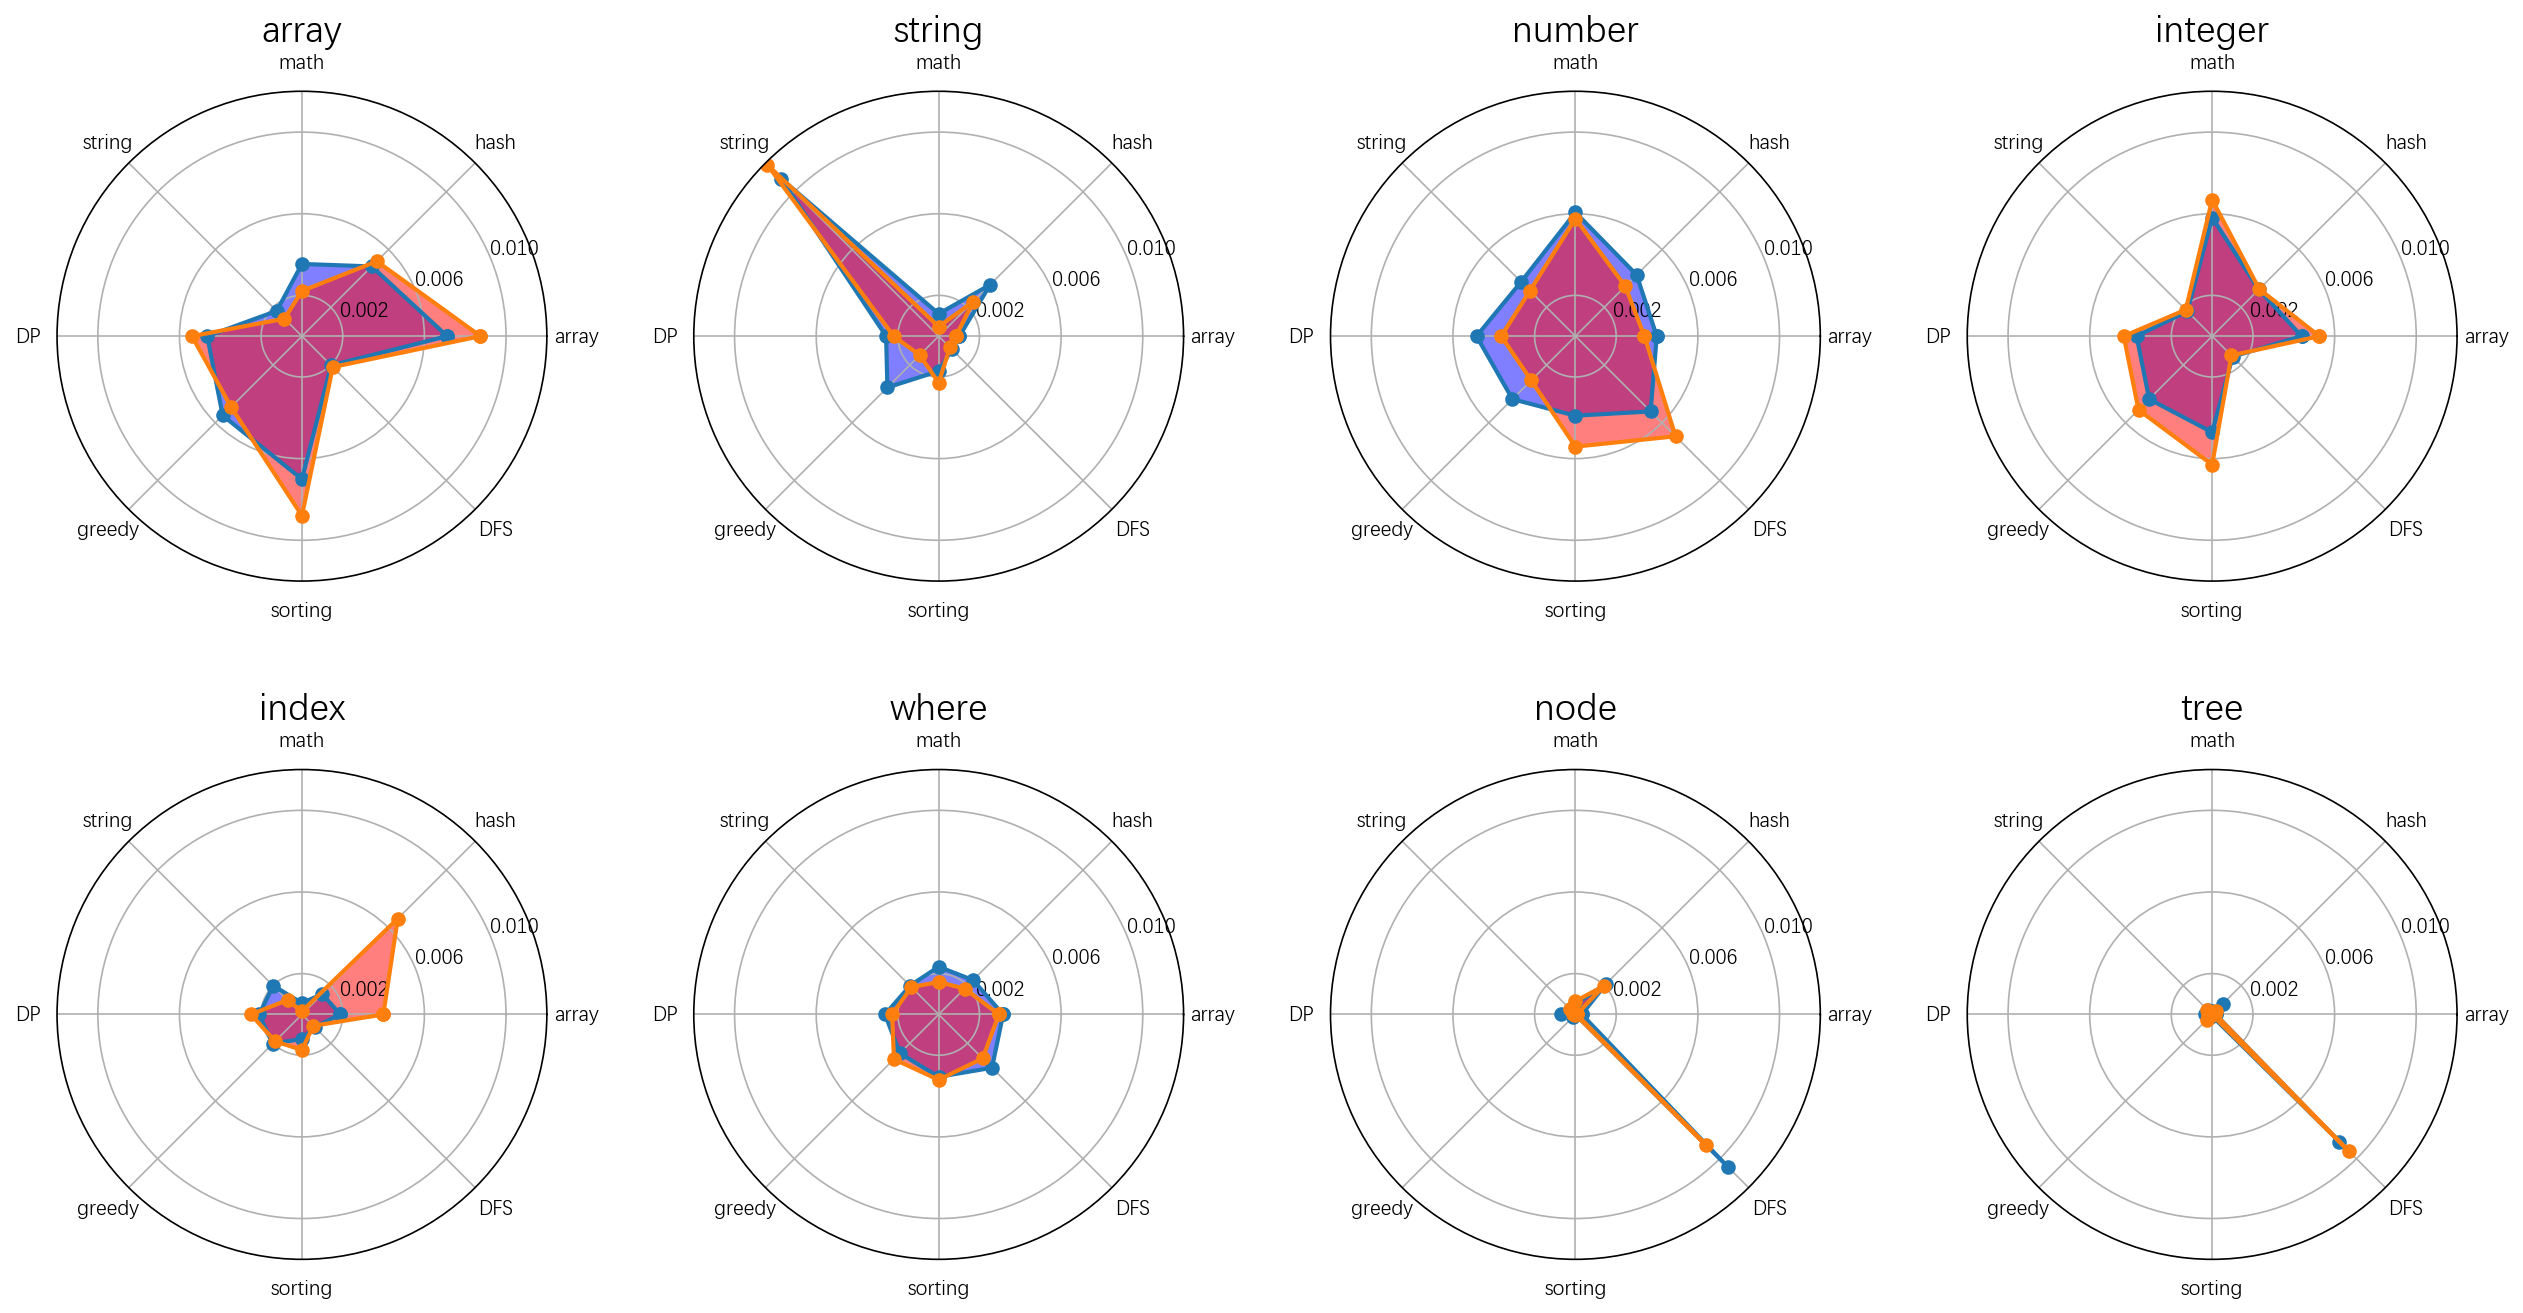

In [9]:
fig = plt.figure(num=1, figsize=(20, 10), dpi=150, clear=True)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, hspace=0.3, wspace=0.3)
angles = np.linspace(0, 2 * np.pi, 9, endpoint=True)
exe_list = ['array', 'string', 'number', 'integer', 'index', 'where', 'node', 'tree']

for i in range(8):
    axe = fig.add_subplot(2, 4, i + 1, polar=True)

    val = np.array(word_glo_ec[exe_list[i]]['num']) / (np.array(type_glo_ec) + 0.0001)
    val = np.clip(val, a_max=1, a_min=0)
    val = val.tolist()
    val.append(val[0])
    axe.plot(angles, val, 'o-', linewidth=2, label='EC dataset')
    axe.fill(angles, val, 'b', alpha=0.5)

    val = np.array(word_glo_kt[exe_list[i]]['num']) / (np.array(type_glo_kt) + 0.0001)
    val = np.clip(val, a_max=1, a_min=0)
    val = val.tolist()
    val.append(val[0])
    axe.plot(angles, val, 'o-', linewidth=2, label='KT dataset')
    axe.fill(angles, val, 'r', alpha=0.5)

    axe.set_thetagrids(angles[:-1] * 180 / np.pi, lbl_list)
    axe.set_title(exe_list[i], fontsize=18)
    axe.set_yticks([0.002, 0.006, 0.01])
    axe.set_ylim(0, 0.012)

plt.savefig('./results/cmp_ec/cmp_ec_data_radar.jpg')
plt.show()